# Faking 10 ROOT Files

1. Always build with 10 files output chunks
1. If the actual number is less than 10, then have zero items in some of the chunks
1. If more than 10 files, try to combine them with uproot5 and dask or similar.

This is just like the previous sample - but now we'll use some simple ROOT files. This is closer to what we will likely have to deal with in ServiceX when we use uproot to deal with this.

Will use a single file and just keep re-reading it.

In [1]:
from pathlib import Path
root_file = Path("0fc6e51a5ea6dea107c195591d20a1b2-15.26710677._000019.pool.root.1")

Explore the file to make sure we know what we have:

In [2]:
import uproot
import awkward as ak
with uproot.open(root_file) as f:
    a = f['treeme']['JetPt'].array(library='ak')
    print(a)
    print(f'Length  = {len(a)}')
    single_file_jet_count = len(ak.flatten(a))
    print(single_file_jet_count)

[[102, 63.1], [69.3, 50.2, 35.7], ..., [114, 46.6, ..., 32.9], [153, 90.5, 54]]
Length  = 50000
135013


Make sure we know how to use `uproot.dask` properly:

493950.0


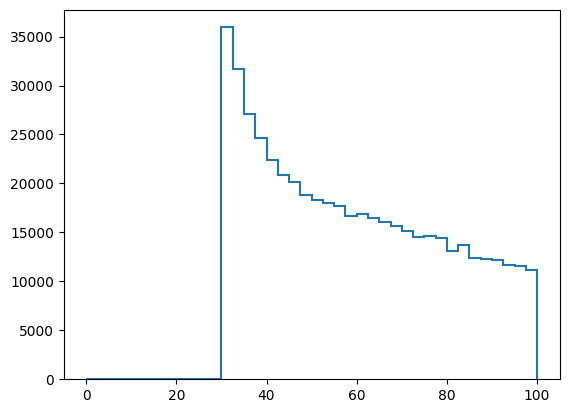

In [3]:
f_repeat = 5

file_list = [root_file for _ in range(0, f_repeat)]
files = uproot.dask(file_list)
pt = files['JetPt']

import dask_histogram as dh
import mplhep as hep
import dask_awkward as dak

h = dh.factory(dak.flatten(pt), axes=(dh.axis.Regular(40, 0, 100),))
r = h.compute()
hep.histplot(r)
print(r.sum())

## Faker

Initialize with the proper number of files we'll eventually generate.

In [4]:
from typing import List
import awkward as ak
import dask_awkward as dak
import dask

def make_input_layer(name: str, inputs: List[str], npartitions=10):
    '''Create an AwkwardInput layer with `inputs` chunks. Each chunk
    has some random numbers in it (100 of them). This will always generate
    10 partitions. If `len(inputs)` is less than 10, then some of the partitions
    will be empty. If `len(inputs)` is greater than 10, then we will
    combine some of them.

    Args:
        name (str): Name of the input layer (for the graph)
        inputs (List[str]): Names of each partition

    Returns:
        AwkwardInputLayer: Input Layer
    '''
    def generate_data(block):
        '''Generate the data for a particular partition. We have the job of
        figuring out how many files per partition.

        Args:
            block (int): The block number
        '''
        files = []
        if len(inputs) <= npartitions:
            if block < len(inputs):
                files = [generate_partition_data(inputs[block])]
            else:
                return ak.from_iter([])
        else:
            num_per = int(len(inputs) / npartitions)
            if block < (len(inputs) - num_per*npartitions):
                num_per += 1
            
            # The indexing has a bug - will come back to this eventually
            # Not important for now.
            block_index = num_per * block
            files = [generate_partition_data(inputs[block_index + i]) for i in range(0, num_per)]

        # files = uproot.dask(file_list)
        # pt = files['JetPt']
        all_pt = [uproot.open(f_name)['treeme']['JetPt'].array(library='ak') for f_name in files]
        pt = ak.concatenate(all_pt)
        return pt

    def generate_partition_data(block):
        '''Generate the partition data for a single block.

        Args:
            block (_type_): _description_

        Returns:
            _type_: _description_
        '''
        print(f'In generate_data: {block}')
        return root_file

    # Build the metadata for this array we will be returning. Each partition
    # will be of this form.
    sample_array = ak.from_iter([[1.0, 2.1], [3.2], [], [4.3, 5.4]])
    metadata = dak.core.typetracer_array(sample_array)

    # Next, create the input layer that will be used to generate the data.
    # Always setup 10 partitions
    dsk = dak.layers.AwkwardInputLayer(
            name=name,
            columns=None,
            inputs=list(range(0, npartitions)),
            io_func=generate_data,
            meta=metadata,
            behavior=None,
        )

    return dsk

def generate_sx_daq(query: str, inputs: List[str] = ['0', '1'], n_partitions = 10) -> dak.Array:
    name = 'unique-name'
    input_layer = make_input_layer(name, inputs, npartitions=n_partitions)

    # Create the high level graph that will hold all of this, and the actual array object
    hlg = dask.highlevelgraph.HighLevelGraph.from_collections(name, input_layer)
    ar = dak.core.new_array_object(hlg, name, meta=input_layer._meta, npartitions=n_partitions)

    return ar

## Make a histogram with exactly 10 partitions

This is the easy case!

In generate_data: b_0In generate_data: b_1
In generate_data: b_2
In generate_data: b_3

In generate_data: b_4
In generate_data: b_5
In generate_data: b_6
In generate_data: b_7
In generate_data: b_8
In generate_data: b_9


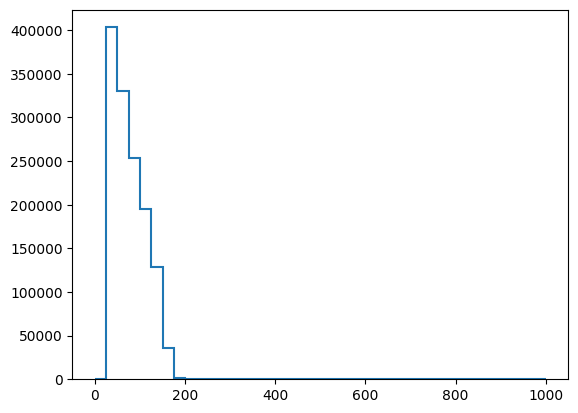

In [5]:
import dask_histogram as dh
import mplhep as hep

x = generate_sx_daq("(query)", inputs=[f'b_{i}' for i in range(0, 10)])
h = dh.factory(dak.flatten(x), axes=(dh.axis.Regular(40, 0, 1000),))
r = h.compute()
hep.histplot(r)

assert r.sum() == single_file_jet_count*10

## Make a histogram with 5 partitions

So 5 of them should be empty.

In [6]:
import dask_histogram as dh
import mplhep as hep

x = generate_sx_daq("(query)", inputs=[f'b_{i}' for i in range(0, 5)])
h = dh.factory(dak.flatten(x), axes=(dh.axis.Regular(20, 0, 1000),))
r = h.compute()
#_ = hep.histplot(r)

assert r.sum() == single_file_jet_count*5

In generate_data: b_0
In generate_data: b_1
In generate_data: b_2
In generate_data: b_3
In generate_data: b_4


## Make a histogram with 15 partitions

This means that some them should have more than one partition in them.

In [7]:
import dask_histogram as dh
import mplhep as hep

x = generate_sx_daq("(query)", inputs=[f'b_{i}' for i in range(0, 15)])
h = dh.factory(dak.flatten(x), axes=(dh.axis.Regular(20, 0, 1000),))
r = h.compute()

assert r.sum() == single_file_jet_count*15

In generate_data: b_0
In generate_data: b_1
In generate_data: b_2
In generate_data: b_3
In generate_data: b_4
In generate_data: b_5
In generate_data: b_6
In generate_data: b_7
In generate_data: b_8
In generate_data: b_9
In generate_data: b_5
In generate_data: b_6
In generate_data: b_7
In generate_data: b_8
In generate_data: b_9
